# Assignment 11

In this assignment we'll examine a data set called `failure_counts.csv`. 

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 

Protip: if you write your `.stan` file generally enough, it will work with most of the models below, and you won't need to keep recompiling the model object!


In [1]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

C:\Users\pfost\anaconda3\envs\ds_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Description of The Data Set

We are interested in estimating the probability of failure of a new type of rocket. We have little to no data on this particular type of rocket (it's new, and rocket launches are expensive). However, the data we *do* have is on *related* rockets. 

This dataset is taken from a Github repository belonging to Alexandre Bouchard-Côté. Each row is a separate type of rocket. For each of those rockets, the data shows how many times that rocket has been launched, as well as how many of those launches have been considered "failures."

Here are the first few rows.



In [2]:
os.chdir('C:\Virginia\Semester3\Bayes\HW11')

In [3]:

rockets = pd.read_csv("failure_counts.csv")
rockets.head()

,LV.Type,numberOfLaunches,numberOfFailures
0,Aerobee,1,0
1,Angara A5,1,0
2,Antares 110,2,0
3,Antares 120,2,0
4,Antares 130,1,1


In [4]:
rockets.describe()

,numberOfLaunches,numberOfFailures
count,367.000000,367.000000
mean,15.441417,1.174387
std,48.514954,2.579257
min,1.000000,0.000000
25%,2.000000,0.000000
50%,4.000000,0.000000
75%,12.000000,1.000000
max,633.000000,22.000000


## Problem 1

Please answer the following general questions. Try to place each subquestion answer in a separate cell to keep everything organized. 

1. Why are the over simplistic and the overly flexible models inappropriate for this data set? Explain why hierarchical models are an essential and important tool to estimate the quantity of interest.
2. Write out a model to conduct inference on this data set. Describe all parts of the complete-data likelihood. Use mathematical notation. Describe how you chose your priors.


Estimate the parameters of your hierarchical model. Attach your modified `.stan` file to your submission so that we may run it when graded your work.

Please be sure to address the following questions about $\theta$ inference:

3. Are the convergence diagnostics satisfactory?
4. Report point and interval estimates for global/top level parameter estimates and *interpret* these parameter estimates. Describe why they make sense.
5. Provide histograms and scatterplots for the posterior $\theta$. Describe why the relationship between all elements of $\theta$ "makes sense."
6. Use a `generated quantities` block to come up with a histogram for the new (completely unobserved) rocket's probability of failure on its first launch. What are the chances that this probability is greater than $.01$?


Regarding the $z$ inference.

7. Provide a plot that shows how related each rocket's failure probability is.
8. Explain why inference on $z$ is not your primary goal.
9. Explain a real-world situation when inference on $z$ *could* be your primary goal. 

Finally:

10. Describe one weakness of the model's assumptions. 
11. How do you think a frequentist would approach this problem differently? 




1) Overly simplistic models, would assume each obseravtion (rocket) would be unrelated and would put a seperate distribution on each row. Each row would be a simple reflection of that row. Whereas an uber flexible model would put all of the data into one large distribution and assume that they all come from that data. The hierarchical model is a good blend of these two techniques.

In [7]:
%%writefile binomial_hier.stan
data {
  int<lower=0> J;         // number of rocketes
  array[J] int<lower=0> n;      // array for the number of launches of each rocket
  array[J] int<lower=0> y;      // array for the number of failures of each rocket
}

parameters {
  real<lower=0> alpha;    // alpha parameter for the Beta distribution
  real<lower=0> beta;     // beta parameter for the Beta distribution
  array[J] real<lower=0, upper=1> z; // probabilities of failure for each rocket
}

model {
  // Priors
  alpha ~ gamma(1, 1);    // Weakly informative prior on alpha
  beta ~ gamma(1, 1);     // Weakly informative prior on beta
  
  // Complete-Data Likelihood
  for (j in 1:J) {
    z[j] ~ beta(alpha, beta);  // hierarchical model
    y[j] ~ binomial(n[j], z[j]); // binomial likelihood
  }
}

generated quantities{
    real mean_p_fail = beta_rng(alpha, beta);
}

Overwriting binomial_hier.stan


2) Above we have the a stan file for a binomial hierarchical model for the probability of failure of the rocket data set. It puts a weakly informative gamma distribution on the to parameters for the beta distribution for the $z_j$ for each observation. The completed data likelihood is joint probability of failures $y$ and the latent variable $z$ as such the likilihood formula is:

$$
    L(y,z|n, \alpha, \beta)
$$

And since we know the general form a Binomial function and a beta prior we can sub our information in and get:

$$
    \prod_{j=1}^J \underbrace{\lbrack {n \choose k} z_j^{y_j} (1-z_j)^{n_j-y_j} \rbrack}_{\text{Likelihood}} \cdot \underbrace{\lbrack \frac{ \Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}z_j^{\alpha-1}(1-z_j)^{\beta-1}  \rbrack}_{\text{Beta Prior}}
$$

In [8]:
model_code = os.path.join(os.getcwd(), 'binomial_hier.stan')
model = CmdStanModel(stan_file=model_code)


07:45:48 - cmdstanpy - INFO - compiling stan file C:\Virginia\Semester3\Bayes\HW11\binomial_hier.stan to exe file C:\Virginia\Semester3\Bayes\HW11\binomial_hier.exe
07:48:24 - cmdstanpy - INFO - compiled model executable: C:\Virginia\Semester3\Bayes\HW11\binomial_hier.exe


In [9]:
stan_data = {
    'J': rockets.shape[0],
    'n': rockets['numberOfLaunches'].values,
    'y': rockets['numberOfFailures'].values
}

In [15]:
fit = model.sample(data = stan_data)

07:59:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                        | 00:00 Status





chain 1 |██████▍                                                                | 00:13 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████████▋                                                             | 00:18 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |████████████▉                                                          | 00:22 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |████████████████▏                                                      | 00:25 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███████████████████▎                                                   | 00:29 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████████████████████▌                                                | 00:32 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████████████████████████▊                                             | 00:35 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |█████████████████████████████                                          | 00:38 I


08:01:15 - cmdstanpy - INFO - CmdStan done processing.
08:01:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Virginia/Semester3/Bayes/HW11/binomial_hier.stan', line 15, column 2 to column 22)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'C:/Virginia/Semester3/Bayes/HW11/binomial_hier.stan', line 15, column 2 to column 22)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'C:/Virginia/Semester3/Bayes/HW11/binomial_hier.stan', line 15, column 2 to column 22)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Virginia/Semester3/Bayes/HW11/binomial_hier.stan', line 15, column 2 to column 22)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Virginia/Semester3/Bayes/HW11/binomial_hier.stan', line 15, column 2 to column 22)
	Exception: gamma_lpdf: Random variable is inf,

The non-fatal error is because some of the values selected for the Beta distibution are exactly zero, which we allow.

In [16]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-1986.670000,1.964510,31.585500,-2040.200000,-1986.230000,-1935.330000,258.50400,2.168150,1.004410
alpha,0.634776,0.005832,0.099905,0.486527,0.625298,0.816599,293.43100,2.461090,1.005040
beta,4.161640,0.043359,0.800982,2.987160,4.098500,5.552610,341.26800,2.862310,1.004330
z[1],0.108364,0.001601,0.122999,0.000894,0.063729,0.376657,5903.15000,49.511400,0.999475
z[2],0.109068,0.001544,0.118240,0.001608,0.068571,0.356493,5866.13000,49.200900,0.999419
...,...,...,...,...,...,...,...,...,...
z[364],0.114363,0.001586,0.125358,0.001543,0.069134,0.391405,6245.83000,52.385600,1.000770
z[365],0.089048,0.000632,0.043867,0.030387,0.082412,0.171861,4813.44000,40.371700,0.999987
z[366],0.058144,0.000993,0.068728,0.000724,0.032521,0.203451,4788.06000,40.158900,0.999438
z[367],0.080107,0.001195,0.094209,0.000644,0.047342,0.271510,6210.00000,52.085100,0.999399


The initial summary of the MCMC has pretty good R_hat values...

In [17]:
np.all(fit.summary()['R_hat'] < 1.01)

True

All of the R_Hat values are less than 1.01 and show a good fit. 

<Axes: >

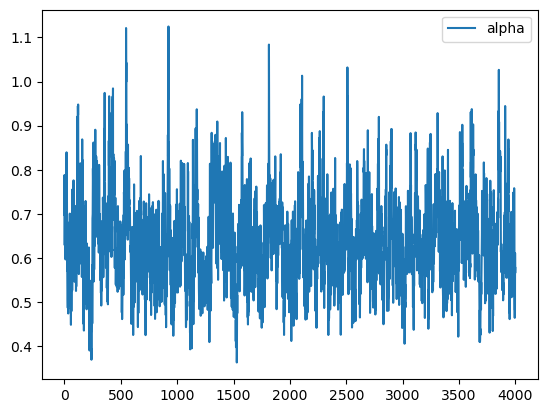

In [21]:
fit.draws_pd('alpha').plot()

<Axes: >

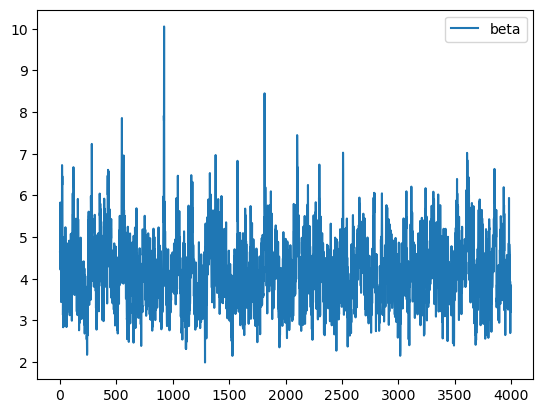

In [22]:
fit.draws_pd('beta').plot()

3) We can see that the convergence diagnostics are good. The R_hats are all less than 1.01. And the MCMC has converged to values that make sense. Further the alpha/beta parameters look like good "fuzzy catepillars"

In [18]:
alphas = fit.stan_variable('alpha')
betas = fit.stan_variable('beta')
z = fit.stan_variable('z')

In [23]:
fit.summary().iloc[1:3,:]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,0.634776,0.005832,0.099905,0.486527,0.625298,0.816599,293.431,2.46109,1.00504
beta,4.161640,0.043359,0.800982,2.987160,4.098500,5.552610,341.268,2.86231,1.00433


The point estimate for alpha is .635, with a 90% CI of .487-.817. The point estimate for beta is 4.16 with a 90% CI of 2.99-5.55.

4) The top level global parameters are the alpha/beta parameters for the beta distribution for the posterior. Alpha in this case the psuedo-failure and beta is the psuedo-success. Here with alpha being much smaller than beta we see that the probability of failure rate of the rockets is quite low. We can find the mean global failure rate by taking: $\frac{\alpha}{\alpha+\beta}$. We can take the point estimates of alpha and beta and put them into the equation to get: $\frac{.635}{.635+4.16} = .132$. Which means the failure rate for rockets is around $13\%$. 

array([[<Axes: xlabel='alpha', ylabel='alpha'>,
        <Axes: xlabel='beta', ylabel='alpha'>],
       [<Axes: xlabel='alpha', ylabel='beta'>,
        <Axes: xlabel='beta', ylabel='beta'>]], dtype=object)

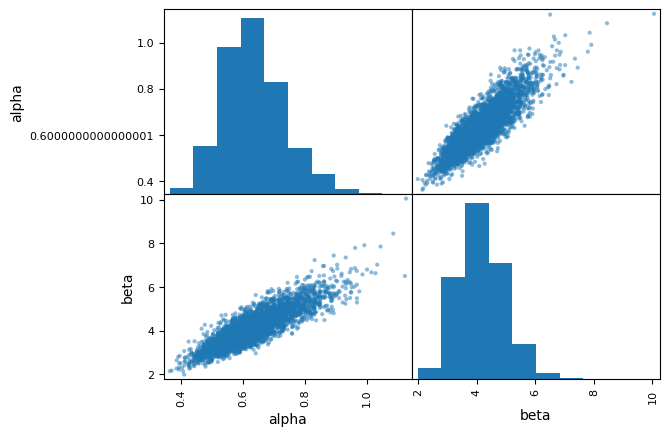

In [19]:
pd.plotting.scatter_matrix(pd.DataFrame({'alpha': alphas, 'beta': betas}))

5) We can see from above scatterplot matrix that the histograms of alpha and beta are consistent with the CIs that were given earlier. Also what is really interesting and important is how positively correlated the alpha and beta are, this means that to maintain the relatively low failure rate, there needs to be a correspondigly high number of launches, which is to be expected.

Text(0, 0.5, 'Count')

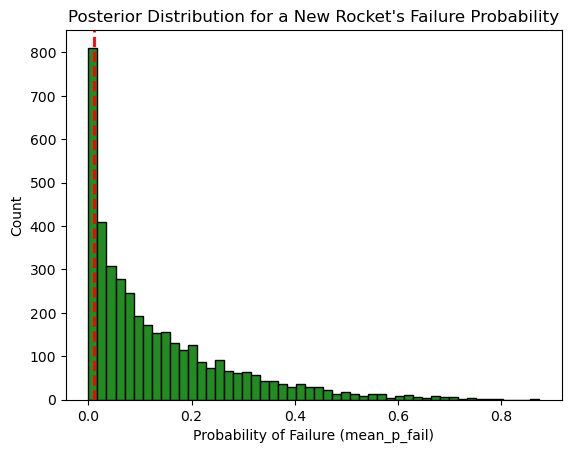

In [35]:
plt.hist(fit.draws_pd()['mean_p_fail'].values, bins = 50, color='forestgreen', edgecolor='black')
plt.axvline(0.01, color='red', linestyle='--', linewidth=2, label='Threshold (0.01)')
plt.title("Posterior Distribution for a New Rocket's Failure Probability")
plt.xlabel("Probability of Failure (mean_p_fail)")
plt.ylabel("Count")

In [32]:
pfail_values =fit.draws_pd()['mean_p_fail'].values

pgreater = np.mean(pfail_values > .01)

pgreater


0.856

6) The probability of failure of a new rocket is quite low, but the probability of failure greater than 1% is 86%. This is evidenced by the large tail on the histogram. While the most frequently occuring probability is 0, Non zero is more frequent in sum.

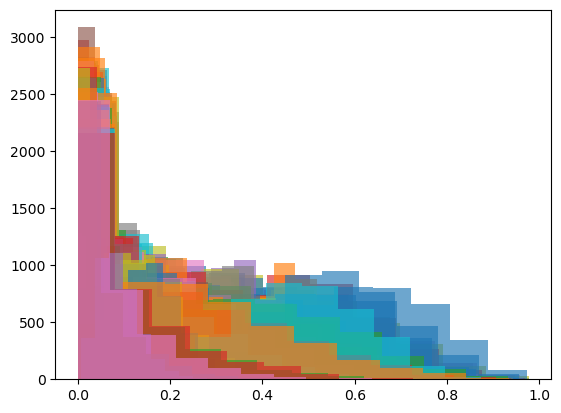

In [36]:
for _ in range(len(rockets)):
    plt.hist(z[:,_], alpha = .65)

7) We can see that all of the zs hug together, most of the distributions hug to the far left, we can see where the tails get pulled to the right.
8) The point is not to infer on the zs, rather to look at the interaction between all of the zs and how they inform the full posterior.
9) If the primary point was to find out which of these was the "outlier" to pull out which may be driving the full posterior.


10) The main problem is the assumption that all of these rockets ARE related, some of them might not be related, or at least not related all together at the same way. They might have different manufacturers or types of fuel or other factors.
11) Obviously a frequentist would not have any prior information for the Beta. Then they would optimize based on the likelihood function instead of the joint probabilty of the likelihood and the prior.

## Hints:

For problem 6, we assume $y_j \mid z_j \sim \text{Binomial}(n_j, z_j)$ for all $j$. *This is true even for $j$s that are from out of sample data.* Let's call the out of sample new rocket $j=368$ because there are $367$ rows in the in sample data.

Now, be careful what you condition on. If you want to be a full Bayesian **you're only allowed to condition on what you know: the observed data.**

By the rules of probability and the assumptions of our model:

$$
p( \text{new rocket fails} \mid y_{1:367}) = \iint p(y_{368} = 1 \mid z_{368}) p(z_{368} \mid \alpha, \beta) \pi(\alpha, \beta \mid y_{1:367}) \text{d}z_{368} \text{d}\theta = \iint z_{368} \text{Beta}(\alpha, \beta)\pi(\alpha, \beta \mid y_{1:367}) \text{d}z_{368} \text{d}\theta 
$$

**Therefore, for each $\alpha, \beta$ sample generated by your MCMC algorithm, use those parameters to sample one $z_{368}$ from a $\text{Beta}(\alpha, \beta)$ distribution. All of those samples of the quantity $z_{368}$ can be plotted as a histogram, or used to estimate the center of the histogram, or tail probabilities of the histogram.**

The reasoning proving why this "works" is because that expression above is a theoretical average (or expectation). *Sample* averages converge to *theoretical* averages by the law of large numbers! 
